# Homework 5: An External Forcing Experiment

Name: Rilee Wadsworth

Date: 09/23/2025

#### Overview
In class, we set up the MITgcm `global_ocean_ebm` configuration with the `exf` package to run on MITgcm. In this assignment, we will assess the output of this model configuration. 

To begin, import the Python modules for manging and plotting data, and making movies. Then, define a path to your homework 5 directory. Finally, the `diags` folder on Spartan to your local machine.

In [1]:
# import pertinent modules
import os
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
import moviepy.video.io.ImageSequenceClip

# define a path to the diags directory
diags_dir = '/Users/rilee/MS 274/Homework/Homework 5/diags'

### Part 1: Choose Variables to Examine 
In this assignment, you'll investigate the relationship between a state variable (temperature, salinity, or velocity) and an associated forcing variable (heat flux, freshwater flux, or wind stress). 

In the markdown cell below, indicate which pair of variables you're going to investigate.

I will investigate temperature and heat flux.

### Part 2: Make a Movie
Next, make a movie for your variables of interest. The movie should show your state variable in one panel and your forcing variable in another panel. If you are using velocity and wind stress, you can either plot the magnitude of these variables or plot the vector components individually.

In [2]:
# define a plot_frame function which takes in two arguments:
def plot_frame(temp_path, flux_path, image_path): 

    # make a figure object
    fig = plt.figure(figsize=(10,6))

    #note: I had to splice the data because I couldn't figure out how to get it to output in different files
    temp_grid = np.fromfile(temp_path, '>f4')[:40*90].reshape((40,90))
    flux_grid = np.fromfile(flux_path, '>f4')[2*40*90 : 3*40*90].reshape((40,90))

    # plot the temp
    plt.subplot(1,2,1)
    plt.pcolormesh(temp_grid, cmap="seismic")
    plt.colorbar(label="C")
    plt.title('Surface Temperature')
    plt.xlabel('Model Columns')
    plt.ylabel('Model Rows')

    #plot flux
    plt.subplot(1,2,2)
    plt.pcolormesh(flux_grid, cmap='bwr')
    plt.colorbar(label='W/m2')
    plt.title('Surface Heat Flux')
    plt.xlabel('Model Columns')
    
    # save a close the figure
    plt.savefig(image_path)
    plt.close(fig)
    

In [3]:
# make a list that will hold the paths
file_list = []

# loop through each day of the year
for i in range(10,7271,20):

    # identify the data file path
    temp_path = os.path.join(diags_dir, 'diagSURF', 'diagSURF.'+'{:010d}'.format(i)+'.data')
    flux_path = os.path.join(diags_dir, 'diagsEXF', 'diagsEXF.'+'{:010d}'.format(i)+'.data')

    # identify the image file path
    image_path = os.path.join(diags_dir, 'plots', 'tempflux', 'TEMPFLUX.'+'{:010d}'.format(i)+'.png')

    # call the plotting function
    plot_frame(temp_path, flux_path, image_path)

    # add the image path to the file path list (for the next step)
    file_list.append(image_path)

In [4]:
# to make movie

# set the frames per second
fps=10

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(file_list, fps=fps)

# write the video to a file
output_file = os.path.join(diags_dir, 'temp_flux_movie.mp4') # fill this in
clip.write_videofile(output_file)

Moviepy - Building video /Users/rilee/MS 274/Homework/Homework 5/diags\temp_flux_movie.mp4.
Moviepy - Writing video /Users/rilee/MS 274/Homework/Homework 5/diags\temp_flux_movie.mp4



Moviepy - Done !
Moviepy - video ready /Users/rilee/MS 274/Homework/Homework 5/diags\temp_flux_movie.mp4


Comment on any features you observe in your movie. Place particular focus on the potential connection(s) between your state variable and the forcing.

For the most part, when heat flux changes from postitive to negative in a region, the surface temperature decreases. This indicates that the ocean is losing heat, which is refleected in our temperature plots. However it is important to note that there is a bit of lag between changes in flux vs. changes in temperature.

### Part 3: Plot Time Series at a Location
Based on your movie, choose an interesting place in your model domain and create a timeseries of your variables at this location. There should be two plots - either as two horizontal subplots (one for each variable), or one plot with two separate y-axes for the different variables.

Again you are using velocity and wind stress, you can either plot the magnitude of these variables or plot the vector components individually.

In [5]:
#open data file in WSL or powersheell to obtain the gridding parameters (PARM4)
delX = 4
delY = 4
xgOrigin = 0
ygOrigin = -80
n_rows = 40
n_cols = 90

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)
# define the lon/lat point
lon = 235
lat = 25

# find its location in the grid
dist = ((XC - lon)**2 + (YC - lat)**2)**0.5
row, col = np.where(dist==np.min(dist))
row, col = row[0], col[0]  
print(row,col)

26 58


In [6]:
# make an empty array for temperature
temp_timeseries = np.zeros((364,))

# loop through all the files
for j, step in enumerate(range(10, 7271, 20)):

    # identify the file
    temp_path = os.path.join(diags_dir,'diagSurf', f'diagSurf.{step:010d}.data')

    # read in data (two fields: THETA, SALT)
    temp_grid = np.fromfile(temp_path, '>f4').reshape(40,90,-1)

    # grab THETA at our location
    temp_timeseries[j] = temp_grid[row, col, 0]

In [7]:
# make your timeseries
# make an empty array
flux_timeseries = np.zeros((364,))

# loop through all the diagsEXF files
for i, step in enumerate(range(10, 7271, 20)):
    # identify the data file path
    flux_path = os.path.join(diags_dir, 'diagsEXF', f'diagsEXF.{step:010d}.data')

    # read in the data (EXF has multiple fields)
    flux_grid = np.fromfile(flux_path, '>f4').reshape(40, 90, 4)

    # sample flux at our location
    flux_timeseries[j] = flux_grid[row, col, 2]

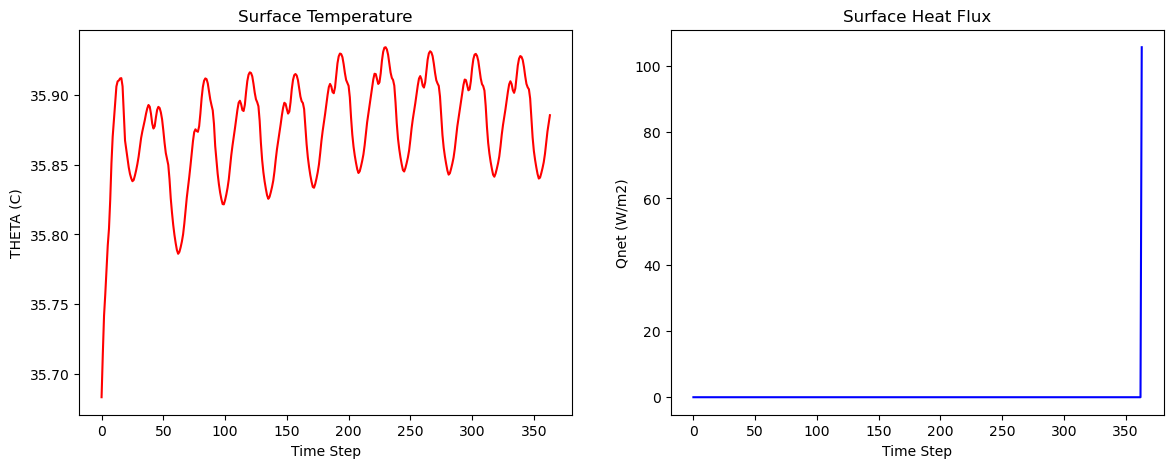

In [8]:
plt.figure(figsize=(14,5))
# plot temperature timeseries
plt.subplot(1,2,1)
plt.plot(temp_timeseries, "r-")
plt.title('Surface Temperature')
plt.xlabel('Time Step')
plt.ylabel('THETA (C)')

# plot heat flux timeseries
plt.subplot(1,2,2)
plt.plot(flux_timeseries, "b-")
plt.title('Surface Heat Flux')
plt.xlabel('Time Step')
plt.ylabel('Qnet (W/m2)')

# show the plot
plt.show()

Comment on any features you observe in your timeseries. Place particular focus on the potential connection(s) between your state variable and the forcing. Is there anything you observe in your timeseries that you didn't catch by eye in your movie?

The THETA timeseries shows that the temperature has some variation, but rather same (a max difference of 0.1), while heat flux shows 0 for almost the entire simulation. Either this chosen cell is near land, or the heatflux is so small that there is not much impact on the surface temperature.